### Description

Meant to be used in JupyterLab, Jupyter Notebook, or VS Code.

This script is for getting **category conversations, SOV, Brand Mentions and Conversations, Word Cloud and Brand Attributes.** <br>
This script can also be used to get groupwise and monthwise count.

Modules required: **CSUtilities.py**, **queries.py** <br>
These modules need to be in same folder as **this** script. Alternatively, they can be included in path (see below).

```
from sys import path
path.append('c:/path/to/the/modules')
```


In [2]:
# import libraries
import pandas as pd
from datetime import date
import numpy as np
import warnings
import time
import CSUtilities as csu
import queries
import matplotlib.pyplot as plt
%matplotlib inline

today = date.today()
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [9]:
# set connection parameters
dbname=''
host=''
port=0
user=''
password=''

### Date Range, Groups, and Model

In [4]:
# date range
date_range = csu.dateRange('2022-06-16', '2022-06-17')
date_range

"createdatutc >= '2022-06-16' and createdatutc <= '2022-06-17 23:59:59'"

In [5]:
# read groups from model file (columns name -> 'groupid')
group_data = pd.read_excel('model.xlsx',sheet_name="groups")
print('duplicate groups:', group_data.duplicated(subset=['groupid']).sum())
groupids = group_data['groupid'].dropna().drop_duplicates()
groupids = tuple(groupids)
print('unique groups:', len(groupids))

duplicate groups: 1
unique groups: 30


In [6]:
# load model file
model = pd.read_excel('model.xlsx',sheet_name="keywords")
model.columns = [x for x in model.iloc[0]]
model = model[1:]
print(model.shape)
model.head()

(121, 5)


,Keywords,Identifier,Main_Subset,Category,Transformations
1,Health,Sub category,Main,Category,"health,sehat, swasth, svasth"
2,Nutrition,Sub category,Main,Category,"nutrition,nutritional,_pusti_,pushti,_পুষ্টি_,..."
3,Diet,Sub category,Main,Category,"_diet_, dieting, kum khaana, kum khana"
4,Nutrients,Sub category,Main,Category,"nutrient, poshak"
5,Vitamin,Sub category,Subset,Category,vitamin


In [7]:
# make transformations
tx = csu.makeModelTransformations(model)
# tx = csu.makeTransformations('#hashtag1, #hashtag2', model=False) # use this line for hashtag mentions
tx

"TEXTLOWER ILIKE '%health%' OR TEXTLOWER ILIKE '%sehat%' OR TEXTLOWER ILIKE '%swasth%' OR TEXTLOWER ILIKE '%svasth%' OR TEXTLOWER ILIKE '%nutrition%' OR TEXTLOWER ILIKE '%nutritional%' OR TEXTLOWER ILIKE '% pusti %' OR TEXTLOWER ILIKE '%pushti%' OR TEXTLOWER ILIKE '% পুষ্টি %' OR TEXTLOWER ILIKE '%nutritious%' OR TEXTLOWER ILIKE '% diet %' OR TEXTLOWER ILIKE '%dieting%' OR TEXTLOWER ILIKE '%kum khaana%' OR TEXTLOWER ILIKE '%kum khana%' OR TEXTLOWER ILIKE '%nutrient%' OR TEXTLOWER ILIKE '%poshak%' OR TEXTLOWER ILIKE '%chawanprash%' OR TEXTLOWER ILIKE '%chawanpras%' OR TEXTLOWER ILIKE '%chavanprash%' OR TEXTLOWER ILIKE '%chavan prash%' OR TEXTLOWER ILIKE '%chyanwanprash%' OR TEXTLOWER ILIKE '%chyawanpras%' OR TEXTLOWER ILIKE '%chyavanpras%' OR TEXTLOWER ILIKE '% keto %' OR TEXTLOWER ILIKE '%intermittent%' OR TEXTLOWER ILIKE '%intermitent%' OR TEXTLOWER ILIKE '%fasting%' OR TEXTLOWER ILIKE '% vrat %' OR TEXTLOWER ILIKE '%upwaas%' OR TEXTLOWER ILIKE '%upvaas%' OR TEXTLOWER ILIKE '% upwas %

### Query
This part generates and executes SQL query. <br>

1. queries.generateSQL('conv') generates SQL query. It can also be printed to see the query. <br>

'conv' - use this to run conversations query. <br>
'mentions' - use this to run mentions query. <br>

2. queries.executeQuery() function takes connection parameters and query from previous function as inputs and outputs the result 'y' in a dataframe. <br>

'backup' variable can be used to restore original query output 'y' if things do go the way you wanted them to...




In [10]:
tick = time.time()
query = queries.generateSQL('conv', groupids, tx, date_range)
y = queries.executeQuery(dbname, host, port, user, password, query=query)
print(f'exec time: {round(time.time()-tick,2)} seconds')
backup = y.copy()

exec time: 22.12 seconds


In [8]:
# restore y
# y = backup.copy()

### Category Conversations
catconv - category conversations df <br>
cc_monthwise - Monthwise category conversations df<br>
grpbycc - Groupwise category conversations df (will only output if **group_wise=True**)<br>

In [11]:
catconv, catconv_all, catconv_h, catconv_o, ccftimestamp, ccltimestamp, cc_monthwise, grpbycc = csu.getKPICount(y, group_wise=False, aho='all')
csu.printCount('Category Conversations', catconv_all, catconv_h, catconv_o, ccftimestamp, ccltimestamp, cc_monthwise, grpbycc)

Category Conversations: 1619 
Category Conversations #: 436 
Category Conversations organic: 1183 
 
First timestamp: 2022-06-16 00:32:42 
Last timestamp: 2022-06-17 22:42:48 

Monthwise Category Conversations
   Keywords  Jun-22
0    Count    1619


In [12]:
csu.printReferenceConv(df=catconv, start_index=0, num_conv=5)

Reference Conversations
────────────────────────────────────────────────────────────────────────────────
hello mommies...i am looking for a gud paedritician or vaccination clinic near ramesh nagar,new delhi ...my sons paedritician is out for few days... kindly provide the name of doctor n the contact no. also on which i can take appointment for vaccination. 
preferable areas in ramesh nagar and nearby would be : ramesh nagar, kirti nagar, moti nagar, patel nagar
tia
────────────────────────────────────────────────────────────────────────────────
thanks for sharing ur baby story dear....yes u said right every child is different n their  growth pattern also....i am also gave bm to my child till 6 n after 6 start semisolids like daliya,dal,khichdi, suji kherr vegetables soups,fruits puree, makhana,potato mashed n banana...but after 6 i have very low bm supply...so i gave dexolac stage 2 fm suggested by my pediatrician...it has all essential nutrients to give our child proper growth n deve

In [16]:
# download dump
# catconv.to_pickle(f'convdump {today}.pickle')
catconv.to_excel(f'convdump {today}.xlsx', index=False)

In [218]:
# organic catconv
organic = catconv[~catconv["textlower"].str.contains("#")]
organic.shape

(9081, 7)

### Make convdump1_0

In [13]:
# create transformations dict
model_dict = csu.makeKeywordDict(model)

In [14]:
# make 1_0 dump
tick = time.time()
catconv1_0 = csu.makeOneZeroDataFrame(catconv, model_dict)                # replace catconv with organic to only use organic conversations
print(catconv1_0.shape)
print(f'exec time: {round(time.time()-tick,2)} seconds')

(1619, 128)
exec time: 2.33 seconds


In [38]:
# catconv1_0.to_pickle(f'convdump1_0 {today}.pickle')
catconv1_0.to_excel(f'convdump1_0 {today}.xlsx',index=False)
# catconv1_0.textlower.to_clipboard(index=False)

### Mentions & SOV

In [14]:
# mentions dataframe
keyword_mentions = csu.calculateSOV(model.Keywords.to_list(), catconv1_0)
keyword_mentions.to_clipboard(index=False, header=False)
keyword_mentions.head(3)

,Keywords,Mentions
0,Health,445
1,Nutrition,51
2,Diet,78


In [15]:
# brands sov dataframe
sov = csu.calculateSOV(model[model.Category == 'Brands'].Keywords.to_list(), catconv1_0)
sov.to_clipboard(index=False, header=False)
sov.head(3)

,Keywords,Mentions
0,Ensure,8
1,Protinex,0
2,Protein x,0


In [16]:
# monthwise keyword mentions dataframe
y2 = catconv1_0.copy()
y2.createdatutc = y2.createdatutc.astype('datetime64[M]')
y2 = y2.groupby('createdatutc')[y2.select_dtypes(include='int8').columns].sum().T.astype('int32')
y2.columns = y2.columns.strftime('%b-%y')
y2 = y2.reset_index().rename_axis(None,axis=1).rename(columns={'index':'Keywords'})
y2.to_clipboard()
y2

,Keywords,Jun-22
0,Health,445
1,Nutrition,51
2,Diet,78
3,Nutrients,32
4,Vitamin,19
...,...,...
116,Protinex,0
117,Protein x,0
118,Mother horlicks,0
119,Prohance,0


In [17]:
# monthwise brands sov dataframe
y2_brand = y2.merge(model[['Keywords','Category']], on='Keywords',how='left')
y2_brand = y2_brand[y2_brand.Category == 'Brands'].iloc[:,:-1]
y2_brand.to_clipboard(index=False)
y2_brand

,Keywords,Jun-22
115,Ensure,8
116,Protinex,0
117,Protein x,0
118,Mother horlicks,0
119,Prohance,0
120,Horlicks Protein Plus,0


In [18]:
# Mentions with their category and conversations row dataframe
s2 = model[['Category', 'Keywords']].merge(y2, on='Keywords', how='right')
s2 = pd.concat([cc_monthwise, s2], ignore_index=True)
s2 = s2[list(s2.columns[-1:]) + list(s2.columns[:-1])]
s2.drop_duplicates(inplace=True)
s2.fillna('Category Conversations', inplace=True)
s2.to_clipboard(index=False)
s2.head(5)

,Category,Keywords,Jun-22
0,Category Conversations,Count,1619
1,Category,Health,445
2,Category,Nutrition,51
3,Category,Diet,78
4,Category,Nutrients,32


In [19]:
# monthwise sov with conversations row dataframe
s2_brand = pd.concat([cc_monthwise, y2_brand])
s2_brand.to_clipboard(index=False)
s2_brand

,Keywords,Jun-22
0,Count,1619
115,Ensure,8
116,Protinex,0
117,Protein x,0
118,Mother horlicks,0
119,Prohance,0
120,Horlicks Protein Plus,0


### Brand Mentions and Conversations

In [15]:
brand = 'Nutrition'  # name should be same as in model

In [16]:
m = catconv1_0[catconv1_0[brand] == 1]
mentions, mentions_c, mentions_h, mentions_o, f_ts, l_ts, m_monthwise, grpbymentions = csu.getKPICount(m, group_wise=False, aho='all')
mentions = mentions.loc[:,['groupid','createdatutc','textlower','senti']]

In [17]:
mentions.head()

,groupid,createdatutc,textlower,senti
15,6df3f44f-d87a-48e8-8bcf-710aa06b56bf,2022-06-16 12:56:50,dear agar feeding ke bad bhi baby roti hai to ...,positive
19,1ba40bb4-7329-453d-a535-20c256a24278,2022-06-16 17:52:29,get recognition for your research by showcasin...,positive
21,6df3f44f-d87a-48e8-8bcf-710aa06b56bf,2022-06-16 18:21:13,"#myhappyhealthybaby\n\nhey mommies,\n\nas i me...",positive
143,2c806dc3-432f-489f-a00e-dbaa270a8de6,2022-06-17 08:09:33,"#myhealthyhappybaby \nin our place, the child ...",positive
151,64771ffc-48af-430b-86c1-863022d52d66,2022-06-16 13:03:19,53% of children with autism spectrum disorder ...,negative


In [18]:
# mentions
csu.printCount('Brand Mentions', mentions_c, mentions_h, mentions_o, f_ts, l_ts, m_monthwise, grpbymentions)

Brand Mentions: 51 
Brand Mentions #: 37 
Brand Mentions organic: 14 
 
First timestamp: 2022-06-16 08:26:41 
Last timestamp: 2022-06-17 19:21:19 

Monthwise Brand Mentions
   Keywords  Jun-22
0    Count      51


In [19]:
# Posts having brand mentions
post_ids = set(m[m.type == 'Post'].sourceid)
len(post_ids)

19

In [20]:
# brand conversations (posts having brand mentions along with all the comments (may or may not have brand mentions) + separate comments with brand mentions)
bc = pd.concat([m, catconv[catconv.parentsourceid.isin(post_ids)]], ignore_index=True).drop_duplicates(subset=['sourceid'])
brandconv, bc_c, bc_h, bc_o, ftimestamp, ltimestamp, bc_monthwise, grpbybc = csu.getKPICount(bc, group_wise=False, aho='all')
brandconv = brandconv.loc[:,['groupid','createdatutc','textlower']]

In [21]:
csu.printCount('Brand Conversations', bc_c, bc_h, bc_o, ftimestamp, ltimestamp, bc_monthwise, grpbybc)

Brand Conversations: 129 
Brand Conversations #: 68 
Brand Conversations organic: 61 
 
First timestamp: 2022-06-16 08:26:41 
Last timestamp: 2022-06-17 19:45:34 

Monthwise Brand Conversations
   Keywords  Jun-22
0    Count     129


In [28]:
csu.printReferenceConv(df=mentions, start_index=0, num_conv=1)

                                                Reference Conversations                                                 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
#Tata1mg #1mg #1mgforevery1 #BringingCareToHealth #RightDiagnosticForAll
This is really very useful and helps to know our health very easily and that by sitting at home
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [44]:
# download mentions
mentions.to_excel(f'mentions {today}.xlsx', index=False)

In [45]:
# upload updated mentions
mentions = pd.read_excel(f'mentions {today}.xlsx')
mentions.shape

(1270, 4)

In [28]:
# sentiments
senti = csu.calculateSentiments(mentions, month_wise=False)
senti.Count.to_clipboard(index=False)
senti

,senti,Count
0,positive,38
1,neutral,3
2,negative,10


In [47]:
# download brand conversations
brandconv.to_excel(f'brandconv {today}.xlsx', index=False)

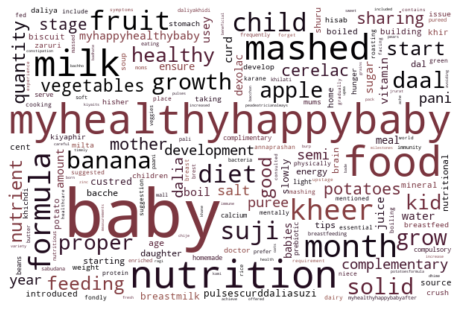

In [26]:
# wordcloud
wc_text = csu.preprocess(' '.join(brandconv.textlower.values))
stopwords = set(pd.read_csv('assets/stop-word-list.csv').dropna().iloc[:,0].to_list()) # stop-word-list.csv must be in the same folder as this script OR provide full path to the file
wc_image = csu.generateWordCloud(wc_text, stopwords=stopwords) 
fig = plt.figure(figsize=(8,6))
plt.imshow(wc_image, interpolation='bilinear')
plt.axis('off')
plt.show()

### Brand Attributes

In [32]:
# read attributes sheet in model file
# first row should contain header (columns - Keywords, Main_Subset, Transformations). All attributes must be main
# transformations can be given in transformation columns or simply copy paste the keywords column (do fix keywords, e.g. try/tried -> try, tried)
attributes = pd.read_excel('model.xlsx', sheet_name='attributes')
print(attributes.shape)
attributes.head(3)

(28, 3)


,Keywords,Main_Subset,Transformations
0,buy,Main,"buy, bought"
1,try,Main,"try, tried"
2,use,Main,"_use_,using, used"


In [33]:
# attributes dictionary and attributes 1_0 dump
att_dict = csu.makeKeywordDict(attributes)
tick = time.time()
bc_for_attr = csu.makeOneZeroDataFrame(brandconv, att_dict)
print(f'exec time: {round(time.time()-tick,2)} seconds')

exec time: 0.05 seconds


In [34]:
# print brand attributes count
brandattr = np.sum(bc_for_attr[attributes.Keywords.tolist()], axis=0)
brandattr.to_clipboard(header=False)
brandattr

buy                             0
try                             3
use                             7
recommend                       7
Daily Moisture                  0
Soothing Relief                 0
Dermexa                         0
Wash                            0
Lotion                          0
Cream                           0
Dry skin                        0
Rashes                          0
Eczema                          0
Atopic Dermatitis               0
Sensitive skin                  0
Very dry skin                   0
Redness                         0
Chapped Cheeks                  0
Skin allergy                    0
US No. 1                        0
Pediatrician Recommended        0
Natural oats                    2
hydrating                       0
moisturizing                    0
Longer hours                    0
Friend recommended              0
24 Hours                        0
Recommended by dermatologist    0
dtype: int64